<a href="https://colab.research.google.com/github/Ashrafalaghbari/regression-problems-prediction/blob/main/FBHP_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [955]:
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from itertools import combinations
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error
from math import inf

In [956]:
df = pd.read_csv("pwf.txt", sep = " ")

In [957]:
df  = df.rename(columns={'MBHP': "FBHP", 'QO': "Oil_rate", 'Qg': "Gas_rate", 'QW': "Water_rate", 'TBG': "Tubing_ID",
                   'API': "Oil_gravity", 'P': "Pwh"})
df = df.iloc[:,1:-1]

In [958]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206 entries, 0 to 205
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   FBHP         206 non-null    int64  
 1   Oil_rate     206 non-null    int64  
 2   Gas_rate     206 non-null    float64
 3   Water_rate   206 non-null    int64  
 4   Tubing_ID    206 non-null    float64
 5   DEPTH        206 non-null    int64  
 6   Oil_gravity  206 non-null    float64
 7   STM          206 non-null    int64  
 8   BTM          206 non-null    int64  
 9   Pwh          206 non-null    int64  
dtypes: float64(3), int64(7)
memory usage: 16.2 KB


In [959]:
df

,FBHP,Oil_rate,Gas_rate,Water_rate,Tubing_ID,DEPTH,Oil_gravity,STM,BTM,Pwh
0,2804,4600,2693.37,11000,4.000,6621,32.6,90,212,175
1,2368,700,411.69,1300,2.441,6271,32.6,90,212,230
2,2343,8616,4230.46,2500,3.813,6294,36.5,156,208,285
3,2161,2983,1023.09,905,3.958,6345,32.8,90,180,220
4,2289,3792,1749.74,3796,4.000,6340,32.6,90,212,210
...,...,...,...,...,...,...,...,...,...,...
201,2483,16437,8136.32,0,3.958,6427,36.5,158,209,280
202,2444,11521,8087.74,1683,3.958,6369,36.5,157,209,400
203,2563,3600,2301.92,1750,3.958,6260,32.6,90,212,640
204,2822,2924,1431.85,7659,3.958,6933,32.6,90,212,225


In [960]:
df.isnull().sum()

FBHP           0
Oil_rate       0
Gas_rate       0
Water_rate     0
Tubing_ID      0
DEPTH          0
Oil_gravity    0
STM            0
BTM            0
Pwh            0
dtype: int64

In [961]:
df.describe()

,FBHP,Oil_rate,Gas_rate,Water_rate,Tubing_ID,DEPTH,Oil_gravity,STM,BTM,Pwh
count,206.000000,206.000000,206.000000,206.000000,206.000000,206.000000,206.000000,206.000000,206.000000,206.000000
mean,2489.033981,6321.514563,3416.071068,2700.009709,3.833660,6359.868932,33.772330,117.733010,203.640777,321.077670
std,302.165572,4835.159680,3068.439643,2793.081243,0.387319,566.278874,2.317918,30.793436,16.957251,153.563251
min,1227.000000,280.000000,33.600000,0.000000,1.995000,4550.000000,30.000000,76.000000,157.000000,80.000000
25%,2288.250000,2543.750000,1051.602500,3.250000,3.813000,6299.750000,32.600000,90.000000,208.000000,210.000000
50%,2500.000000,4761.500000,2454.525000,1834.500000,3.958000,6509.500000,32.600000,90.000000,212.000000,280.000000
75%,2700.500000,9576.000000,4918.515000,5033.500000,3.958000,6712.750000,36.500000,155.000000,212.000000,390.000000
max,3217.000000,19618.000000,13562.200000,11000.000000,4.000000,7100.000000,37.000000,160.000000,215.000000,960.000000


In [962]:
df.iloc[148:152]

,FBHP,Oil_rate,Gas_rate,Water_rate,Tubing_ID,DEPTH,Oil_gravity,STM,BTM,Pwh
148,2482,2700,1508.92,6600,4.000,6308,32.6,90,212,210
149,2920,2900,1531.59,9300,3.958,6803,32.6,90,212,210
150,2876,600,169.09,2200,3.958,6901,32.8,90,180,140
151,2522,6396,4266.13,5256,3.813,6780,36.5,155,213,190


# Examining the scatter plot of paired data

In [963]:
# def corrdot(*args, **kwargs):
#     corr_r = args[0].corr(args[1], 'pearson')
#     corr_text = f"{corr_r:2.2f}".replace("0.", ".")
#     ax = plt.gca()
#     marker_size = abs(corr_r) * 10000
#     ax.scatter([.5], [.5], marker_size, [corr_r], alpha=0.6, cmap="coolwarm",
#                vmin=-1, vmax=1, transform=ax.transAxes)
#     font_size = abs(corr_r) * 40 + 5
#     ax.annotate(corr_text, [.5, .5,],  xycoords="axes fraction",
#                 ha='center', va='center', fontsize=font_size)

# sns.set(style='white', font_scale=1.6)

# g = sns.PairGrid(df, aspect=1.4, diag_sharey=False)

# g.map_upper(sns.regplot, lowess=True, ci=False, line_kws={'color': 'black'})
# g.map_diag(sns.histplot, kde_kws={'color': 'black'})
# g.map_lower(corrdot)

In [964]:
# create higher order terms and interaction terms to capture non-linearity for TRAINING SET
# Linear transformation (subtraction) and centering predictors to reduce multicollinearity
df['Oil_rate_C'] = df['Oil_rate'] - df['Oil_rate'].mean()
df['Gas_rate_C'] = df['Gas_rate'] - df['Gas_rate'].mean()
df['Oil_rate**2'] = df['Oil_rate_C']**2
df['Gas_rate**2'] = df['Gas_rate_C']**2
df['DEPTH_C'] = df['DEPTH'] -  df['DEPTH'].mean()
df['DEPTH**2'] = df['DEPTH_C']**2
df['Pwh_C'] = df['Pwh'] -  df['Pwh'].mean()
df['DEPTH*Pwh'] = df['DEPTH'] * df['Pwh']
df['DEPTH*Pwh_C'] = df['DEPTH_C'] * df['Pwh_C']
df['Pwh**2'] = df['Pwh_C']**2
df['Oil*Gas'] = df['Oil_rate_C'] * df['Gas_rate_C']
df['BTM_STM_diff'] = df['BTM'] - df['STM']
# create dummy variable for Tubing_ID
tubing_binary_train = pd.get_dummies(df['Tubing_ID'], prefix='Tubing_Id')
df = pd.concat([df, tubing_binary_train], axis=1)
# remove the last dummy variable
# df = df.drop(['Oil_rate_C','Gas_rate_C','Tubing_Id_4.0'], axis=1)
df = df.drop(['Tubing_Id_4.0'], axis=1)

In [965]:
# split data into 80% training and 20% test sets
train_X, test_X, train_y, test_y = train_test_split(df.iloc[:,1:], df.iloc[:,0:1], test_size=0.2, random_state=42)
print(f'Training set: {train_X.shape} shape')
print(f'Test set: {test_X.shape} shape')

Training set: (164, 26) shape
Test set: (42, 26) shape


In [966]:
# remove outliers based on scatter plot and findings from cook-distance
train_y.loc[train_y['FBHP'] < 1500]
train_X.drop(102, inplace=True)
train_y.drop(102, inplace=True)
train_X.loc[145, 'Water_rate'] = 0

In [388]:
# Linearly transform predictors
column_names = []
LinearTransform = []
for col in train_X.corr():
    column_names.append(col)
    for i in np.arange(-2, 2.5, 0.5):
        X = train_X[col]**i
        linear_correlation = pd.concat([X, train_y], axis=1).corr().iloc[-1,0]
        LinearTransform.append([i, linear_correlation])
    linear_correlation = pd.concat([np.log(X), train_y], axis=1).corr().iloc[-1,0]
    LinearTransform.append(["LOG", linear_correlation])
LinearTransform = pd.DataFrame(LinearTransform, columns=["Transformation", "Correlation"])
LinearTransform["Variable"] = np.repeat(column_names, len(np.arange(-2, 2.5, 0.5)) + 1)

# Group the data by column 'B'
grouped = LinearTransform.groupby('Variable')

# Apply the idxmax function to each group
max_index = grouped['Correlation'].idxmax()

# Extract the rows corresponding to the max value in each group
result = LinearTransform.loc[max_index]

#merge the perason correlation before and after transformation
train = pd.concat([train_X, train_y], axis=1).corr().iloc[-1]
result = result.merge(train, left_on='Variable', right_index=True)
# rename the columns according to the specified transformations
result = result.rename(columns={
    'Transformation': 'Transformation_type',
    'Correlation': 'After_transformation',
    'FBHP': 'Before_transformation'
})

# # reorder the columns according to the specified order
result = result.reindex(columns=['Variable', 'Before_transformation', 'After_transformation', 'Transformation_type'])
result.iloc[np.r_[:13,-1],]


/usr/local/lib/python3.8/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,Variable,Before_transformation,After_transformation,Transformation_type
79,BTM,0.486856,0.486993,LOG
149,BTM_STM_diff,0.127057,0.155443,LOG
48,DEPTH,0.583889,0.588680,2.0
19,Gas_rate,0.183315,0.256058,LOG
127,Gas_rate**2,0.167442,0.172007,1.5
107,Gas_rate_C,0.183315,0.499763,1.5
138,Oil*Gas,0.183490,0.189790,2.0
59,Oil_gravity,0.374125,0.382906,LOG
8,Oil_rate,0.021012,0.069035,2.0
118,Oil_rate**2,0.151397,0.159357,2.0


In [967]:
# Normalize the training and test data
scaler = MinMaxScaler()
normalized_train_X= scaler.fit_transform(train_X)
normalized_test_X= scaler.transform(test_X)
train_X = pd.DataFrame(normalized_train_X, columns = train_X.columns) 
# train_X = train.iloc[:,1:]
# train_y = train.iloc[:,0:1]
test_X = pd.DataFrame(normalized_test_X, columns = test_X.columns)
# test_X = test.iloc[:,1:]
# test_y = test.iloc[:,0:1]

print(f'Training set: {train_X.shape} shape')
print(f'Test set: {test_X.shape} shape')

Training set: (163, 26) shape
Test set: (42, 26) shape


In [ ]:
def reduce_vif(X, threshold=10.0):
    '''
    Returns a dataframe of predictor combinations with VIF values below a given threshold
    
    df : pandas dataframe
        dataframe containing all the predictors to be considered
    threshold : float
        vif threshold value
    '''
    result = []
    # Loop through all possible combinations of predictors
    for n in range(2, len(X.columns)):
        for combination in combinations(X.columns, n):
            # Calculate VIF for the predictors in the current combination
            x = X[list(combination)]
            vif = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]
            # If the maximum VIF is below the threshold, add the combination to the result list
            if max(vif) < threshold:
                result.append((max(vif), str(list(combination))))
    # Return the result list as a dataframe
    return pd.DataFrame(result, columns=['VIF', 'combinations'])

def fit_model(combination, X, y):

    # Add a constant to the predictors for the intercept term
    predictors = sm.add_constant(X[combination])
    # Fit the MLR model
    model = sm.OLS(y.values, predictors).fit()
    adj_rsquared = model.rsquared_adj

    # Initialize the max_adj_rsquared and best_combination variables
    max_adj_rsquared = -inf
    best_combination = None

    # If the current combination has a higher R-squared than the previous best, update the max R-squared and best combination       

    if adj_rsquared > max_adj_rsquared:
        max_adj_rsquared = adj_rsquared
        best_combination = combination
    return best_combination, max_adj_rsquared


X = train_X
y = train_y
# Reduce the predictors to only those with VIF values below the threshold
results_VIF = reduce_vif(X, threshold=10.0)
# Convert the combinations in the result_VIF dataframe from tuples to lists
result_VIF = [ast.literal_eval(item) for item in results_VIF['combinations']]
# Fit MLR models for each combination of predictors and store the best combination and max R-squared for each
best_combinations = [fit_model(com, X, y) for com in result_VIF]
# Convert the list of best combinations and max R-squareds to a dataframe
best_combinations_rsq = pd.DataFrame(best_combinations, columns=['best_combinations', 'adj_rsquared'])
# calculate the number of variables for each combination 
best_combinations_rsq['combination_count'] = best_combinations_rsq['best_combinations'].apply(len)
best_combinations_rsq.sort_values("adj_rsquared", ascending = False)

/usr/local/lib/python3.8/dist-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,best_combinations,adj_rsquared,combination_count
29479,"[Water_rate, DEPTH, Pwh, Oil_rate**2, Gas_rate...",0.749659,7
39335,"[Water_rate, DEPTH, Pwh, Oil_rate**2, Gas_rate...",0.748750,8
39337,"[Water_rate, DEPTH, Pwh, Oil_rate**2, Gas_rate...",0.748099,8
17382,"[Water_rate, DEPTH, Pwh, Gas_rate_C, Oil_rate*...",0.748029,6
14559,"[Gas_rate, Water_rate, DEPTH, Pwh, Oil_rate**2...",0.748029,6
...,...,...,...
1343,"[Oil_rate, Tubing_ID, Tubing_Id_2.441, Tubing_...",-0.011901,4
135,"[Oil_rate_C, Tubing_Id_2.992]",-0.012388,2
13,"[Oil_rate, Tubing_Id_2.992]",-0.012388,2
295,"[Oil_rate, Tubing_Id_2.441, Tubing_Id_2.992]",-0.014136,3


In [983]:
# extract the independent variables
X = train_X[[
'Oil_rate**2', 'DEPTH','Water_rate','Tubing_Id_1.995', 'Pwh'
]]

# calculate the VIF for each variable
vif = pd.DataFrame()
vif["variables"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif

,variables,VIF
0,Oil_rate**2,1.923406
1,DEPTH,8.864528
2,Water_rate,3.412152
3,Tubing_Id_1.995,1.077637
4,Pwh,3.496959


In [984]:
#fit a MLR model
predictors = sm.add_constant(train_X[['Oil_rate**2', 'DEPTH','Water_rate','Tubing_Id_1.995', 'Pwh']] )
# Fit the MLR model
model = sm.OLS(train_y.reset_index().iloc[:,-1].values, predictors).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.779
Model:                            OLS   Adj. R-squared:                  0.772
Method:                 Least Squares   F-statistic:                     110.4
Date:                Fri, 17 Feb 2023   Prob (F-statistic):           1.47e-49
Time:                        22:29:40   Log-Likelihood:                -1032.4
No. Observations:                 163   AIC:                             2077.
Df Residuals:                     157   BIC:                             2095.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            1759.3482     40.008     

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


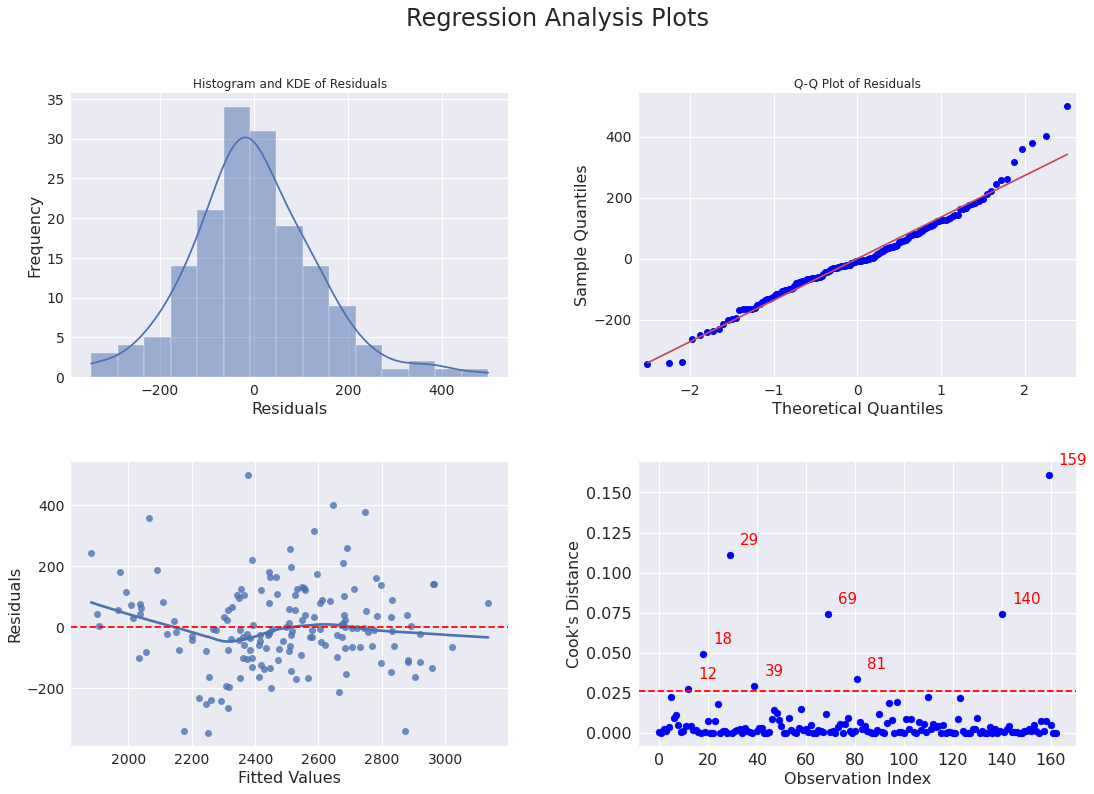

In [986]:
exog = model.model.exog
resid = model.resid

# Set the style of the plot
sns.set_style('darkgrid')

# Create a figure with two subplots, arranged in a 2x2 grid
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 12))

# Plot the histogram and KDE on the first subplot
sns.histplot(resid, kde=True, ax=ax1)
ax1.set_title('Histogram and KDE of Residuals')

# Set the font size for the axes labels and ticks for the first subplot
ax1.tick_params(labelsize=14)
ax1.set_xlabel('Residuals', fontsize=16)
ax1.set_ylabel('Frequency', fontsize=16)



# Generate the Q-Q plot on the second subplot
sm.qqplot(resid, line='s', ax=ax2)
ax2.set_title('Q-Q Plot of Residuals')

# Set the font size for the axes labels and ticks for the third subplot
ax2.tick_params(labelsize=14)
ax2.set_xlabel('Theoretical Quantiles', fontsize=16)
ax2.set_ylabel('Sample Quantiles', fontsize=16)


# Plot the residual plot on the third subplot
sns.regplot(model.fittedvalues, resid, lowess=True, ax=ax3)
# Add horizontal lines at y=300 and y=-300 on the second subplot
# ax3.axhline(y=300, color='red', linestyle='--')
ax3.axhline(y=-0, color='red', linestyle='--')

# Increase font size of x and y labels and ticks for the second subplot
ax3.set_xlabel('Fitted Values', fontsize=16)
ax3.set_ylabel('Residuals', fontsize=16)
ax3.tick_params(labelsize=14)


# Calculate Cook's distance
influence = model.get_influence()
cooks_d = influence.cooks_distance[0]

# Observations that have a Cook-distance value that is 4 times larger than the mean value of
# Cook-distance will be classified as influential observations
threshold = cooks_d.mean() * 4
influential_points = np.where(cooks_d > threshold)[0]

# Create the Cook's distance plot on the fourth subplot
ax4.scatter(range(len(exog)), cooks_d, color='blue')

# Add a horizontal line showing the threshold
ax4.axhline(y=threshold, color='red', linestyle='--')

# Label the influential points on the Cook's distance plot
for i in influential_points:
    ax4.annotate(str(i), (i, cooks_d[i]), xytext=(10, 10), textcoords='offset points', fontsize=15, color='red')

# Set the font size for the axes labels and ticks for the fourth subplot
ax4.tick_params(labelsize=14)
ax4.set_xlabel('Observation Index', fontsize=16)
ax4.set_ylabel("Cook's Distance", fontsize=16)

# Add labels and title to the plot
fig.suptitle('Regression Analysis Plots', fontsize=24)

# Set the font size of the tick labels
plt.tick_params(labelsize=16)

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.3, hspace=0.3)

# Show the plot
plt.show()


In [985]:
from scipy.stats import shapiro

# Perform Shapiro-Wilk test
stat, p = shapiro(model.resid)

# Interpret results
alpha = 0.01
if p > alpha:
    print('Data looks Gaussian (fail to reject H0)')
else:
    print('Data does not look Gaussian (reject H0)')

Data looks Gaussian (fail to reject H0)


In [988]:
# Inverse transform the scaled data back to the original values
inversed_train_X = pd.DataFrame(scaler.inverse_transform(train_X), columns = df.iloc[:,1:].columns)
inversed_train_X = inversed_train_X[['Water_rate',
'Oil_rate**2', 'DEPTH','Water_rate','Tubing_Id_1.995', 'Pwh'
]]
inversed_train_X.iloc[influential_points]

,Water_rate,Oil_rate**2,DEPTH,Water_rate,Tubing_Id_1.995,Pwh
12,0.0,2.929182e+06,5100.0,0.0,0.0,140.0
18,0.0,1.342089e+06,6406.0,0.0,0.0,180.0
29,0.0,2.630166e+07,6597.0,0.0,1.0,560.0
39,0.0,1.702630e+08,6756.0,0.0,0.0,295.0
69,2200.0,3.273573e+07,6901.0,2200.0,0.0,140.0
81,1131.0,3.069730e+07,6700.0,1131.0,0.0,560.0
140,2634.0,2.565944e+07,6285.0,2634.0,0.0,760.0
159,130.0,1.135363e+07,6630.0,130.0,1.0,180.0


In [989]:
# Calculate predicted values for training set 
constant = pd.Series(np.ones((train_X.shape[0],)))
train_predictors = pd.concat([constant, train_X[['Oil_rate**2', 'DEPTH','Water_rate','Tubing_Id_1.995', 'Pwh']]], axis=1)

train_pred_y = model.predict(train_predictors)
r_squared_train = r2_score(train_y, train_pred_y)
# Calculate RMSE value 
rmse_train = np.sqrt(mean_squared_error(train_y, train_pred_y))
# # Calculate r-square value 
print(f"Traning R-Squared: {r_squared_train:.2f}")
print(f"Training RMSE: {rmse_train:.2f}")

Traning R-Squared: 0.78
Training RMSE: 136.33


In [990]:
# Calculate predicted values for testing set 
constant = pd.Series(np.ones((test_X.shape[0],)))
test_predictors = pd.concat([constant, test_X[['Oil_rate**2', 'DEPTH','Water_rate','Tubing_Id_1.995', 'Pwh']]], axis=1)

test_pred_y = model.predict(test_predictors)
r_squared_test = r2_score(test_y, test_pred_y)
# Calculate RMSE value 
rmse_test = np.sqrt(mean_squared_error(test_y, test_pred_y))
# # Calculate r-square value 
print(f"Testing R-Squared: {r_squared_test:.2f}")
print(f"Testing RMSE: {rmse_test:.2f}")

Testing R-Squared: 0.78
Testing RMSE: 132.10


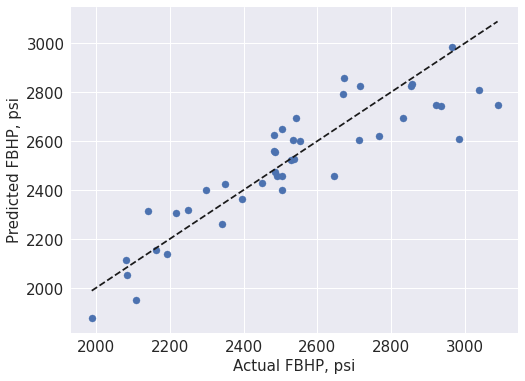

In [991]:
# cross plot
fig, ax = plt.subplots(1, 1, figsize=(8,6))
# Create a scatter plot
ax.scatter(test_y, test_pred_y, marker='o', s=50, c='b', alpha=1)

# Add a 45-degree line
ax.plot([np.min(test_y),np.max(test_y)], [np.min(test_y),np.max(test_y)], 'k-', linestyle='dashed')

# Add labels and a title
plt.xlabel("Actual FBHP, psi", fontsize=15)
plt.ylabel("Predicted FBHP, psi",  fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# plt.savefig("cross plot.png", dpi=1600, bbox_inches='tight')
# Show the plot
plt.show()